<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Tuning substreams output rate

## Goal

The goal of this notebook is to show how users can tune the output rate of existing substreams in Fink. We will make an example on the [Early Supernova type Ia filter](https://github.com/astrolabsoftware/fink-filters/blob/master/fink_filters/filter_early_sn_candidates/filter.py). This filter uses 6 criteria to select likely Early Supernova type Ia candidates from the ZTF data stream:

1. Ia probability larger than 50% from the early supernova Ia module [2111.11438](https://arxiv.org/abs/2111.11438), `rf_snia_vs_nonia`
2. Ia probability larger than 50% from either one of the deep learning classifier based on SuperNNova [1901.06384](https://arxiv.org/abs/1901.06384), `snn_sn_vs_all` & `snn_snia_vs_nonia`
3. no match with galactic objects from the SIMBAD database, `cdsxmatch`
4. non-bogus probability higher than 50% from the RealBogus algorithm (Ma- habal et al. 2019; Duev et al. 2019), `rb`
5. Star/Galaxy classification score from SExtractor above 40% (Bertin, E. & Arnouts, S. 1996), `classtar`
6. the associated object holds no more than 20 photometric measurements (above 3 sigma) `ndethist`

One can refine those substreams, by defining a different threshold on the rate. In practice, as each substream is generated from a combination of parameters, you need to define which parameter(s) to tune. In this notebook we focus on (1) and/or (2) only, as others are more "quality cuts" (but feel free to explore!):


- `rf_snia_vs_nonia`: returns the probability of an alert to be a SNe Ia using a Random Forest Classifier (binary classification)
- `snn_*`: returns the probability of an alert to be a SNe Ia using SuperNNova. Two pre-trained models:
    - `snn_snia_vs_nonia`: Ia vs core-collapse SNe
    - `snn_sn_vs_all`: SNe vs. anything else (variable stars and other categories in the training)




### Method

For the purpose of the test, we will retrieve all alerts (and not objects) that were considered as Early supernova type Ia candidates over 2021 using the Fink REST API, and retro-actively apply new thresholds. In practice, users would do the same on the thresholds, but using the [livestream](https://github.com/astrolabsoftware/fink-client) service.

## Environment set up

To run this notebook, you need to import the following libraries:

In [1]:
import requests
import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

APIURL = 'https://api.fink-portal.org'

### Retrieve past candidates

Each night, alerts are cross-matched in real-time against the CDS SIMBAD database. About 30% of the stream (after applying quality cuts) ends-up with a counter-part. Classified alerts can be then queried using the Fink API service. To know all available classes in Fink, see https://api.fink-portal.org/api/v1/classes. We will first focus on alerts (and not objects) that were considered as Early supernova type Ia candidates over 2021 (can take 1-2 minutes):

In [2]:
# Get latests alerts in a time window
r = requests.post(
  '{}/api/v1/latests'.format(APIURL),
  json={
    'class': 'Early SN Ia candidate',
    'n': '3000' ,                  # number of alerts
    'startdate': '2021-01-01',  # use a start date
    'stopdate': '2021-10-31',   # use a stop date
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [3]:
cols = [
    'd:rf_snia_vs_nonia',
    'd:snn_sn_vs_all',
    'd:snn_snia_vs_nonia',
    'd:cdsxmatch',
    'i:rb',
    'i:classtar',
    'i:nid',
    'i:objectId'
]

pdf[cols]

,d:rf_snia_vs_nonia,d:snn_sn_vs_all,d:snn_snia_vs_nonia,d:cdsxmatch,i:rb,i:classtar,i:nid,i:objectId
0,0.937,0.392669,0.776787,Unknown,0.938571,0.984,1763,ZTF21achhwdz
1,0.632,0.372673,0.750715,Unknown,0.887143,0.987,1763,ZTF21acfeuld
2,0.839,0.280746,0.686907,Unknown,0.917143,0.983,1763,ZTF21acenkuf
3,0.897,0.645492,0.672251,Unknown,0.808571,0.984,1763,ZTF21aceugys
4,0.632,0.315279,0.644493,Unknown,0.768571,0.972,1763,ZTF21acfeuld
...,...,...,...,...,...,...,...,...
2995,0.865,0.716451,0.818727,Unknown,0.908571,0.983,1513,ZTF21aajaljq
2996,0.693,0.837303,0.841222,Unknown,0.934286,0.993,1513,ZTF21aahargb
2997,0.585,0.513644,0.691454,Unknown,0.594286,0.961,1513,ZTF21aahlbxc
2998,0.907,0.713279,0.806600,Unknown,0.761429,0.967,1513,ZTF21aagmqic


In [4]:
nnid = len(np.unique(pdf['i:nid']))

print('Considering {} nights'.format(nnid))

Considering 195 nights


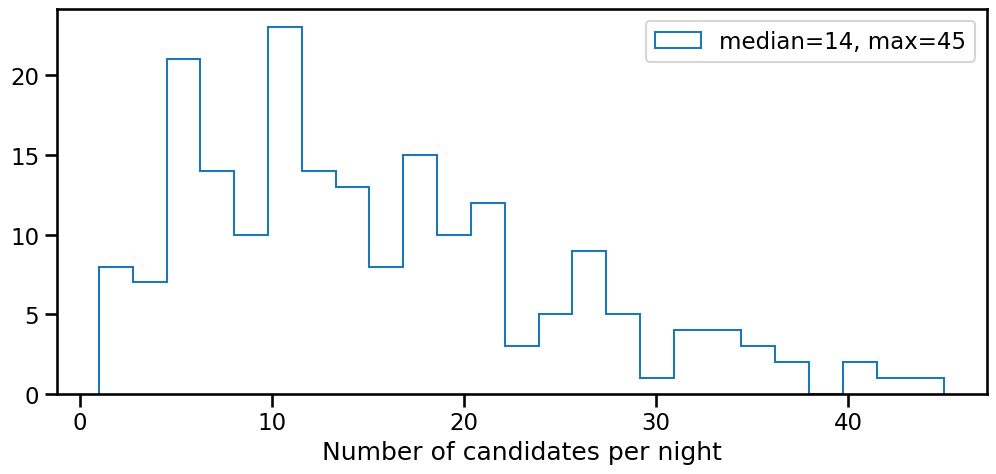

In [5]:
fig = plt.figure(figsize=(12, 5))

nnids = pdf[cols].groupby('i:nid').count()['i:objectId'].values

med_ = np.median(nnids)
max_ = np.max(nnids)

hist, ncand, _ = plt.hist(
    nnids, 
    histtype='step', 
    bins=25, 
    label='median={:.0f}, max={:.0f}'.format(med_, max_)
)

plt.xlabel('Number of candidates per night')
plt.legend();

In [6]:
print('Median at {:.0f} candidates per day, and a maximum of {:.0f} candidates in a night'.format(med_, max_))

Median at 14 candidates per day, and a maximum of 45 candidates in a night


Let's inspect the distribution for the ML scores:

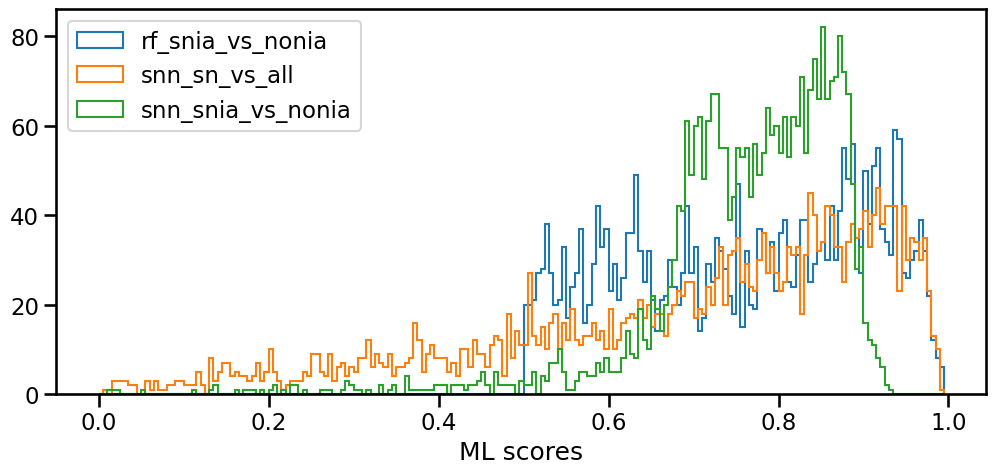

In [7]:
fig = plt.figure(figsize=(12, 5))

n_rfscore = pdf[cols].groupby('d:rf_snia_vs_nonia').count()['i:objectId'].values

bins = np.arange(0.0, 1.0, 0.5/100)

plt.hist(pdf['d:rf_snia_vs_nonia'], histtype='step', bins=bins, label='rf_snia_vs_nonia')
plt.hist(pdf['d:snn_sn_vs_all'], histtype='step', bins=bins, label='snn_sn_vs_all')
plt.hist(pdf['d:snn_snia_vs_nonia'], histtype='step', bins=bins, label='snn_snia_vs_nonia')
plt.xlabel('ML scores')
plt.legend(loc='upper left');

Note that we require `rfscore > 0.5 & (snn_sn_vs_all > 0.5 | snn_snia_vs_nonia > 0.5)`, hence one of the two `snn_*` score can go below 0.5 (but not both at the same time).

## 1D case

Let's vary the parameters individually, and see the effect on the output rate. If we just set for example the Ia probability `rfscore` larger than 90% from the early supernova Ia module (instead of 50%), we obtain:

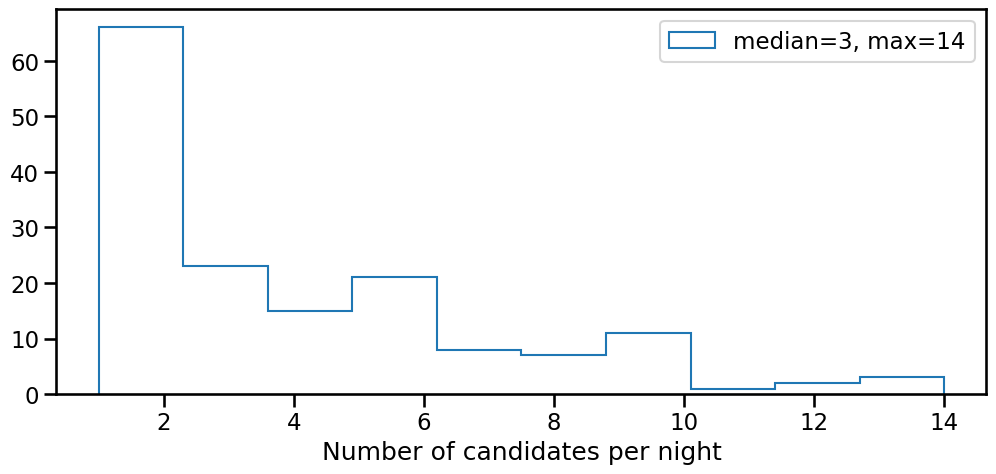

In [8]:
fig = plt.figure(figsize=(12, 5))

f1 = pdf['d:rf_snia_vs_nonia'] > 0.9

nnids = pdf[cols][f1].groupby('i:nid').count()['i:objectId'].values

med_ = np.median(nnids)
max_ = np.max(nnids)

hist, ncand, _ = plt.hist(
    nnids, 
    histtype='step', 
    bins=10, 
    label='median={:.0f}, max={:.0f}'.format(med_, max_)
)

plt.xlabel('Number of candidates per night')
plt.legend();

The median goes from 9/night to 3/night. Let's inspect this more programatically:

In [9]:
def extract_stats_from_ml_threshold(pdf, key, nsteps=20):
    start = 0.5
    stop = 1.0
    step = (stop - start) / nsteps
    bins = np.arange(start, stop, step)

    medians, maxs = [], []
    for score_ in bins:
        f1 = pdf[key] > score_

        nids = pdf[f1].groupby('i:nid').count()['i:objectId'].values

        if len(nids) > 0:
            medians.append(np.median(nids))
            maxs.append(np.max(nids))
        else:
            medians.append(0)
            maxs.append(0)
            
    return bins, medians, maxs

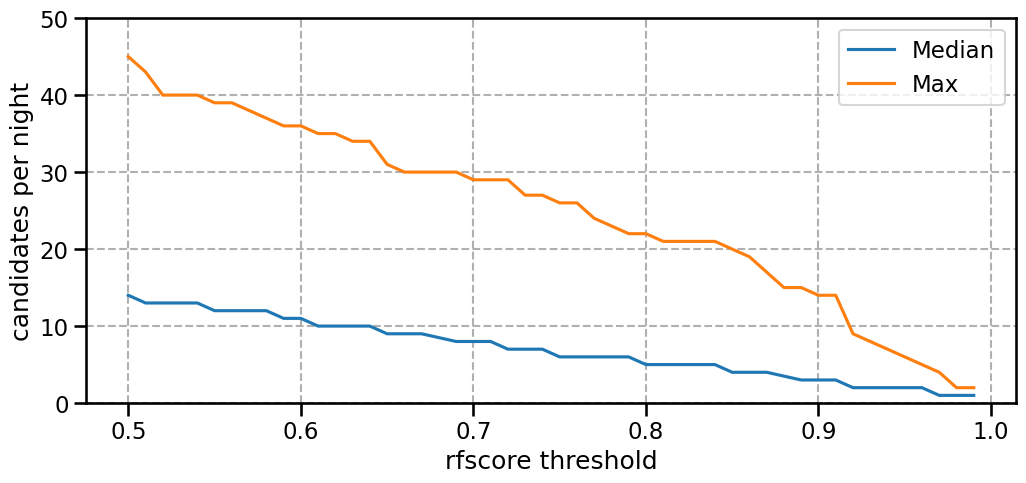

In [10]:
bins, medians, maxs = extract_stats_from_ml_threshold(pdf, key='d:rf_snia_vs_nonia', nsteps=50)
    
fig = plt.figure(figsize=(12, 5))

plt.plot(bins, medians, label='Median')
plt.plot(bins, maxs, label='Max')
plt.xlabel('rfscore threshold')
plt.ylabel('candidates per night')
plt.legend()
plt.grid(ls='--')
plt.ylim(0, 50);

one can see that for very high probabilities, the number of of candidates quickly drops. The same for the two other parameters:

(0.0, 50.0)

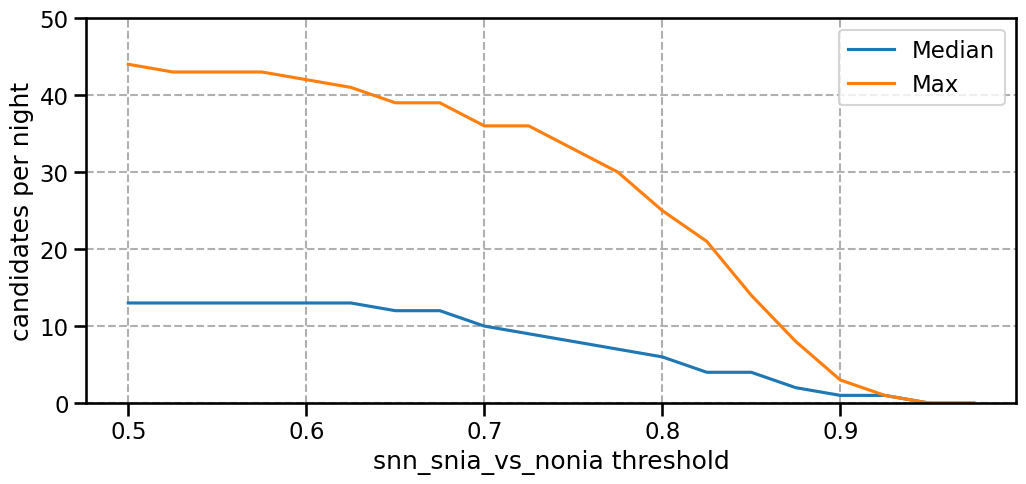

In [11]:
bins, medians, maxs = extract_stats_from_ml_threshold(pdf, key='d:snn_snia_vs_nonia', nsteps=20)
    
fig = plt.figure(figsize=(12, 5))

plt.plot(bins, medians, label='Median')
plt.plot(bins, maxs, label='Max')
plt.xlabel('snn_snia_vs_nonia threshold')
plt.ylabel('candidates per night')
plt.legend()
plt.grid(ls='--')
plt.ylim(0, 50)

(0.0, 50.0)

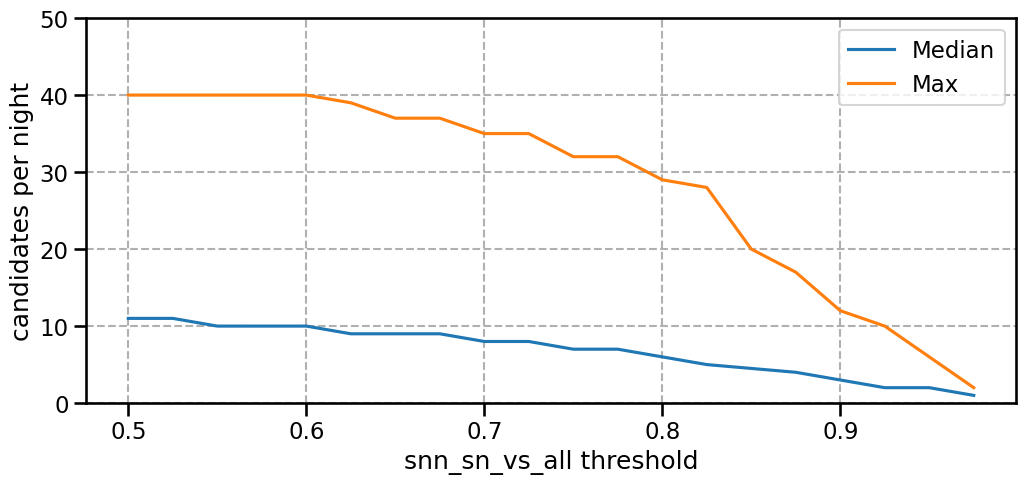

In [12]:
bins, medians, maxs = extract_stats_from_ml_threshold(pdf, key='d:snn_sn_vs_all', nsteps=20)
    
fig = plt.figure(figsize=(12, 5))

plt.plot(bins, medians, label='Median')
plt.plot(bins, maxs, label='Max')
plt.xlabel('snn_sn_vs_all threshold')
plt.ylabel('candidates per night')
plt.legend()
plt.grid(ls='--')
plt.ylim(0, 50)

## N-D case

I'll let users playing with N-dimensional parameter space (several parameters at once) :-)